# <span style="color: blue;">ให้กรอกรหัสนิสิต และชื่อ-นามสกุลของสมาชิกในทีม</span>
# <span style="color: blue;">(ห้ามมีสมาชิกเกิน 2 คน)</span>
## รหัสนิสิต ชื่อ-นามสกุล
<span style="color: green;">6714450249 นายหรินทร์ ธนะนาม</span>

## Building a CNN to classify images in the CIFAR-10 Dataset

We will work with the CIFAR-10 Dataset.  This is a well-known dataset for image classification, which consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The 10 classes are:

<ol start="0">
<li> airplane
<li>  automobile
<li> bird
<li>  cat
<li> deer
<li> dog
<li>  frog
<li>  horse
<li>  ship
<li>  truck
</ol>

For details about CIFAR-10 see:
https://www.cs.toronto.edu/~kriz/cifar.html

For a compilation of published performance results on CIFAR 10, see:
http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html

---

### Building Convolutional Neural Nets

In this exercise we will build and train our first convolutional neural networks.  In the first part, we walk through the different layers and how they are configured.  In the second part, you will build your own model, train it, and compare the performance.

In [13]:
import os

# must come *before* any Tensorflow import
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [14]:
from __future__ import print_function
import random, numpy as np
import keras, tensorflow as tf

from keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
def set_seed(seed_value=12345):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

tf.config.list_physical_devices('GPU')

[]

In [16]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

In [17]:
# The data, shuffled and split between train and test sets:
(_x_train, _y_train), (_x_test, _y_test) = cifar10.load_data()
(x_train, y_train), (x_test, y_test) = (_x_train, _y_train), (_x_test, _y_test)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [18]:
## Each image is a 32 x 32 x 3 numpy array
x_train[444].shape, x_train[444].dtype 

((32, 32, 3), dtype('uint8'))

[9] truck


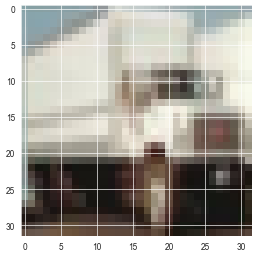

In [19]:
## Let's look at one of the images

image_no = 444
print(y_train[image_no], class_names[y_train[image_no][0]])

plt.figure(figsize=(5, 5), dpi=60)
plt.imshow(x_train[image_no])
plt.show()

In [20]:
num_classes = 10

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [21]:
# now instead of classes described by an integer between 0-9 we have a vector with a 1 in the (Pythonic) 9th position
y_train[444]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [22]:
# As before, let's make everything float and scale
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

## <span style="color:red"> เพื่อป้องกันผลกระทบจากการสุ่ม (randomness) ให้ใช้ค่า seed เป็น 12345 โดยให้เรียกใช้ฟังก์ชัน set_seed(12345) ทุกครั้งก่อนที่จะสร้างโมเดล และให้กำหนดค่า seed ด้วยในการแบ่งข้อมูล </span>
## <span style="color:red"> นอกจากนี้ ห้ามใช้ Early Stopping หรือใช้ Best Weights ในการเทรนโมเดล </span>

## <span style="color:blue"> ส่วนการแบ่งข้อมูล </span>

## <span style="color:green"> 1. (20 คะแนน) ให้แบ่งชุดข้อมูล train ออกเป็น 2 ส่วนในอัตราส่วน 90:10 และข้อมูลทั้ง 2 ส่วนนี้ให้แต่ละคลาสมีจำนวนข้อมูลเท่ากัน โดยข้อมูลที่ถูกแบ่งให้เก็บอยู่ในชุดข้อมูลที่เป็น train และ val ตามลำดับ หลังจากที่แบ่งข้อมูลเสร็จ ให้แสดงจำนวนข้อมูลของแต่ละคลาสในชุดข้อมูล train และ val </span>

## <span style="color:blue"> ส่วนการเทรนโมเดล </span>

In [23]:
set_seed(12345)

# Let's build a CNN using Keras' Sequential capabilities
model_1 = Sequential()

## 5x5 convolution with 1x1 stride and 16 filters
model_1.add(Conv2D(16, (5, 5), strides=(1, 1), padding='same',
                   input_shape=x_train.shape[1:], activation='relu',
                   name='conv_1'))

## Another 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides=(2, 2), padding='valid', 
                   activation='relu', name='conv_2'))

## 2x2 max pooling reduces to 7 x 7 x 32
model_1.add(MaxPooling2D(pool_size=(2, 2), name='pool_1'))

## Flatten turns 7x7x32 into 1568x1
model_1.add(Flatten(name='flatten_1'))
model_1.add(Dense(64, activation='relu', name='dense_1'))
model_1.add(Dense(num_classes, activation='softmax', name='dense_2'))

model_1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 32, 32, 16)     │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 14, 14, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,114 (449.66 KB)

 Trainable params: 115,114 (449.66 KB)

 Non-trainable params: 0 (0.00 B)

## <span style="color:green"> 2. (20 คะแนน) ให้ใช้ชุดข้อมูล train และ val เพื่อเทรนโมเดล model_1 ตามที่กำหนดโครงสร้างไว้ให้ด้านบน โดยให้ใช้จำนวน epoch ไม่น้อยกว่า 20 รอบ หลังจากเทรนโมเดลเสร็จ ให้แสดงกราฟ Loss และ Accuracy พร้อมแสดงค่า Accuracy ที่วัดได้จากชุดข้อมูล train และ val </span>

## <span style="color:green"> 3. (30 คะแนน) ให้แสดงตารางภาพ Confusion Matrix และ Classification Report (ดังตัวอย่างในรูป) จากผลการทำนายของโมเดลด้วยข้อมูล test </span>
![Classification Report](https://drive.google.com/thumbnail?id=1f6Hh-LNsj7mWdNsyT3LRPxAcy73Oa6c_&sz=h360)

$
\begin{align}
Accuracy &= \frac{TP + TN}{TP + TN + FP + FN} \\
Precision &= \frac{TP}{TP + FP} \\
Recall &= \frac{TP}{TP + FN} \\
F1-Score &= \frac{2}{\frac{1}{Precision} + \frac{1}{Recall}} = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}
\end{align}
$


$
\begin{align}
&\text{where TP: True Positives, TN: True Negatives, FP: False Positives, and FN: False Negatives}
\end{align}
$

In [ ]:
# Used sklern to generate classification report and confusion matrix
# Confusion Matrix

## <span style="color:green"> 4. (30 คะแนน) ให้สร้างโมเดลใหม่ที่มีโครงสร้างซับซ้อนมากขึ้น โดยสามารถใช้รูปแบบโครงสร้างดังนี้ </span>

~~~python
Conv -> Conv -> MaxPool -> Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classifier
(ให้ใช้ stride เป็น 1 สำหรับทุกเลเยอร์ convolutional)
~~~

## <span style="color:green"> และให้เทรนโมเดลใหม่เพื่อให้ได้ accuracy ที่ดีขึ้นจากชุดข้อมูล test ซึ่งในการเทรนนี้ ให้ใช้จำนวน epoch ไม่น้อยกว่า 20 รอบ โดยหลังจากเทรนโมเดลเสร็จ ให้แสดง </span>
### * <span style="color:green"> กราฟ Loss และ Accuracy พร้อมแสดงค่า Accuracy ที่วัดได้จากชุดข้อมูล train และ val </span>
### * <span style="color:green"> ตารางภาพ Confusion Matrix และ Classification Report จากผลการทำนายของโมเดลด้วยข้อมูล test </span>
### * <span style="color:green"> ภาพที่โมเดลใหม่ทำนายผิดของคลาสที่มี f1-score สูงสุดมาอย่างน้อย 3 ภาพ โดยแสดงภาพให้ปรากฏ แสดงข้อความว่าภาพนั้นเป็นภาพของคลาสอะไร และโมเดลทำนายผิดเป็นคลาสอะไร </span>

In [ ]:
# Use Accuracy from train from this model vs previous model